In [1]:
import numpy as np
import os
import torch
import pandas as pd
import yaml

from sklearn.externals import joblib

from pytorch_utils.cfvae_models import CFVAEModel

In [2]:
outcome = 'los'
sensitive_variable = 'age'
data_path = 'data/'

features_path = os.path.join(data_path, 'features', str(0), '{}_excluded'.format(sensitive_variable))
label_path = os.path.join(data_path, 'labels')
checkpoints_path = os.path.join(data_path, 'checkpoints', 'scratch', outcome)
performance_path = os.path.join(data_path, 'performance', 'scratch', outcome)

In [3]:
config_load_path = os.path.join(data_path, 'config', 'defaults', 'cfvae', outcome, sensitive_variable, 'model_config.yaml')
checkpoint_load_path = os.path.join(data_path, 'checkpoints', 'cfvae_default', outcome, sensitive_variable, str(0))
os.listdir(checkpoint_load_path)[0]

'1552673022.8390067.chk'

In [4]:
os.makedirs(checkpoints_path, exist_ok=True)
os.makedirs(performance_path, exist_ok=True)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
features_dict = joblib.load(os.path.join(features_path, 'features.pkl'))
master_label_dict = joblib.load(os.path.join(label_path, 'label_dict.pkl'))

In [7]:
data_dict = {split: features_dict[split]['features'] for split in features_dict.keys()}
label_dict = {split : master_label_dict[split][outcome] for split in master_label_dict.keys()}
group_dict = {split : master_label_dict[split][sensitive_variable] for split in master_label_dict.keys()}

In [8]:
group_map = pd.read_csv(os.path.join(label_path, '{}_map.csv'.format(sensitive_variable)))

In [9]:
group_map

,category_id,categories
0,0,"[18, 30)"
1,1,"[30, 45)"
2,2,"[45, 65)"
3,3,"[65, 89)"


In [10]:
with open(config_load_path, 'r') as fp:
    config_dict = yaml.load(fp)

In [11]:
config_dict

{'batch_size': 512,
 'drop_prob': 0.25,
 'drop_prob_classifier': 0.25,
 'gamma': None,
 'group_embed_dim': 64,
 'hidden_dim_classifier': 128,
 'input_dim': 368113,
 'iters_per_epoch': 100,
 'lambda_classification': 10.0,
 'lambda_kl': 0.0,
 'lambda_mmd': 10000.0,
 'lambda_mmd_group': 1000.0,
 'lambda_reconstruction': 1000.0,
 'latent_dim': 128,
 'lr': 0.0001,
 'lr_final_classifier': 0.001,
 'normalize': False,
 'normalize_classifier': True,
 'num_epochs': 20,
 'num_groups': 4,
 'num_hidden': 1,
 'num_hidden_classifier': 2,
 'output_dim': 2,
 'resnet': False,
 'resnet_classifier': False,
 'sparse': True,
 'sparse_mode': 'binary'}

In [12]:
config_dict_final_classifier = {
    'lr_final_classifier' : 1e-2,
    'lambda_final_classifier_cf' : 1e0,
    'lambda_clp' : 1e1,
    'lambda_clp_entropy' : 0e0,
    'num_epochs' : 3,
    'weighted' : False,
    'num_samples_eval': 1,
    'cf_gradients' : False
}

# config_dict_final_classifier = {
#     'lr_final_classifier' : 1e-2,
#     'lambda_final_classifier_cf' : 0e0,
#     'lambda_clp' : 0e1,
#     'lambda_clp_entropy' : 0e0,
#     'num_epochs' : 3,
#     'weighted' : False,
#     'num_samples_eval': 1,
#     'cf_gradients' : True
# }

config_dict.update(config_dict_final_classifier)

In [13]:
if sensitive_variable == 'gender':
    data_dict = {k: v[group_dict[k] < 2] for k,v in data_dict.items()}
    label_dict = {k: v[group_dict[k] < 2] for k,v in label_dict.items()}
    group_dict = {k: v[group_dict[k] < 2] for k,v in group_dict.items()}

In [14]:
model = CFVAEModel(config_dict)

In [15]:
model.load_weights(os.path.join(checkpoint_load_path, os.listdir(checkpoint_load_path)[0]))

In [16]:
result = model.train_final_classifier(data_dict, label_dict, group_dict)

Epoch 0/2
----------
Phase: train:
 loss: 0.330041, classification: 0.330041, classification_cf: 0.326687, clp: 1.070565, clp_entropy: 0.663142,
 auc: 0.883524, auprc: 0.692765, brier: 0.097054,
Phase: val:
 loss: 0.410802, classification: 0.410802, classification_cf: 0.273980, clp: 0.243799, clp_entropy: 0.551969,
 auc: 0.833115, auprc: 0.574982, brier: 0.124193,
Best model updated
Epoch 1/2
----------
Phase: train:
 loss: 0.252357, classification: 0.252357, classification_cf: 0.265120, clp: 1.031958, clp_entropy: 0.564901,
 auc: 0.934415, auprc: 0.799557, brier: 0.077121,
Phase: val:
 loss: 0.415234, classification: 0.415234, classification_cf: 0.270724, clp: 0.226176, clp_entropy: 0.561092,
 auc: 0.835042, auprc: 0.574174, brier: 0.127632,
Epoch 2/2
----------
Phase: train:
 loss: 0.247763, classification: 0.247763, classification_cf: 0.264710, clp: 0.988868, clp_entropy: 0.573402,
 auc: 0.935968, auprc: 0.810856, brier: 0.075519,
Phase: val:
 loss: 0.410836, classification: 0.41083

In [17]:
result_eval = model.predict_final_classifier(data_dict, label_dict, group_dict, phases = ['val', 'test'])
result_eval[1]

{'val': {'auc': [0.8327423796641084],
  'auprc': [0.5748824450496889],
  'brier': [0.12414658114984203],
  'loss': [0.4124212230627353],
  'classification': [0.4124212230627353]},
 'test': {'auc': [0.8341434413734852],
  'auprc': [0.5602280632375226],
  'brier': [0.12150247017730385],
  'loss': [0.406576646062044],
  'classification': [0.406576646062044]}}

In [18]:
result_eval_CLP = model.predict_final_classifier_CLP(data_dict, label_dict, group_dict, 
                                                     phases = ['val', 'test'])

In [19]:
cf_dict = result_eval_CLP[2]
cf_df = pd.concat({key: pd.DataFrame(cf_dict[key]) for key in cf_dict.keys()}).rename_axis(index = ['phase', 'id']).reset_index(0)

In [20]:
cf_df.head()

,phase,y,y_cf,group,group_cf,pred_prob_factual,pred_prob_cf,output_factual,output_cf
id,,,,,,,,,
0,test,0,0,3,0,0.031011,0.016756,-2.233965,-2.497749
1,test,0,0,3,0,0.014956,0.010218,-2.246483,-2.400265
2,test,0,0,2,0,0.010632,0.008525,-2.654529,-2.761294
3,test,0,0,2,0,0.371587,0.263346,-0.813954,-1.117028
4,test,1,1,2,0,0.888014,0.882769,0.931860,0.889044


In [21]:
cf_df = cf_df.assign(pred_diff = lambda x: x.pred_prob_cf - x.pred_prob_factual)
cf_df.head(10)

,phase,y,y_cf,group,group_cf,pred_prob_factual,pred_prob_cf,output_factual,output_cf,pred_diff
id,,,,,,,,,,
0,test,0,0,3,0,0.031011,0.016756,-2.233965,-2.497749,-0.014255
1,test,0,0,3,0,0.014956,0.010218,-2.246483,-2.400265,-0.004738
2,test,0,0,2,0,0.010632,0.008525,-2.654529,-2.761294,-0.002107
3,test,0,0,2,0,0.371587,0.263346,-0.813954,-1.117028,-0.108241
4,test,1,1,2,0,0.888014,0.882769,0.931860,0.889044,-0.005245
5,test,1,0,2,0,0.215087,0.112191,-0.899828,-1.346518,-0.102896
6,test,0,0,3,0,0.033129,0.016918,-2.177666,-2.494870,-0.016212
7,test,0,0,2,0,0.182593,0.078071,-1.165575,-1.718503,-0.104522
8,test,1,0,3,0,0.863559,0.857688,0.728422,0.690384,-0.005871


In [22]:
cf_df.groupby(['y', 'y_cf']).apply(lambda x: x.shape)

y  y_cf
0  0       (55419, 10)
   1        (6951, 10)
1  0        (8777, 10)
   1        (6634, 10)
dtype: object

In [23]:
result = cf_df.groupby(['phase', 'y', 'y_cf', 'group', 'group_cf'])[['pred_diff']].agg(np.mean)

In [24]:
result = result.reset_index()

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

0 0


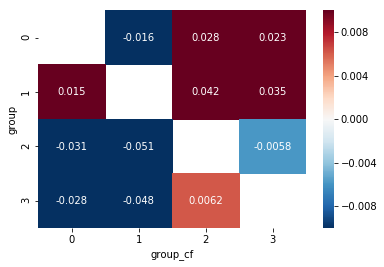

0 1


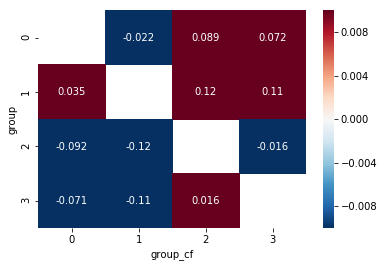

1 0


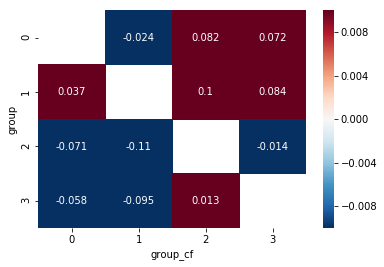

1 1


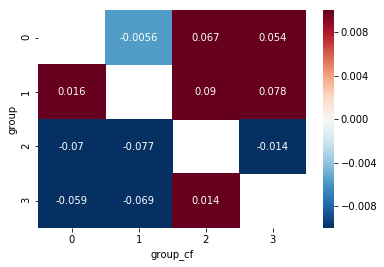

In [26]:
for y in [0, 1]:
    for y_cf in [0, 1]:
        print(y, y_cf)
        temp = result[(result.phase == 'val') & (result.y == y) & (result.y_cf == y_cf)]
        temp = temp.pivot('group', 'group_cf', 'pred_diff')
        ax = sns.heatmap(temp, annot = True, center = 0, cmap = 'RdBu_r', vmin = -0.01, vmax = 0.01)
        plt.show()

In [27]:
from sklearn.calibration import calibration_curve

cal = calibration_curve(cf_df.y, cf_df.pred_prob_factual, n_bins = 10)
print(cal)

(array([0.06900383, 0.22761359, 0.28005373, 0.33449175, 0.371484  ,
       0.49090909, 0.5380774 , 0.59677419, 0.7278415 , 0.85663082]), array([0.02039306, 0.14502354, 0.24695717, 0.34921212, 0.44881929,
       0.54974891, 0.64909602, 0.75074944, 0.85313507, 0.91609889]))


In [28]:
## Get performance by group
sensitive_variables = ['age', 'gender', 'race_eth']
data_dict_by_group = {sensitive_variable: {} for sensitive_variable in sensitive_variables}
label_dict_by_group = {sensitive_variable: {} for sensitive_variable in sensitive_variables}
group_dict_by_group = {sensitive_variable: {} for sensitive_variable in sensitive_variables}
for sensitive_variable in sensitive_variables:
    groups = np.unique(master_label_dict['train'][sensitive_variable])
    for group in groups:
        data_dict_by_group[sensitive_variable][group] = {split: 
                                     data_dict[split][master_label_dict[split][sensitive_variable] == group]
                                     for split in data_dict.keys()
                                    }
        label_dict_by_group[sensitive_variable][group] = {split: 
                                     label_dict[split][master_label_dict[split][sensitive_variable] == group]
                                     for split in data_dict.keys()
                                    }
        group_dict_by_group[sensitive_variable][group] = {split: 
                                     group_dict[split][master_label_dict[split][sensitive_variable] == group]
                                     for split in data_dict.keys()
                                    }

result_df_by_group = pd.concat({sensitive_variable: 
                          pd.concat({
                              group: model.process_result_dict(model.predict_final_classifier(data_dict_by_group[sensitive_variable][group],
                                                                             label_dict_by_group[sensitive_variable][group], 
                                                                             group_dict_by_group[sensitive_variable][group],
                                                  phases = ['val', 'test'])[1])
                              for group in data_dict_by_group[sensitive_variable].keys()
                          })
                          for sensitive_variable in data_dict_by_group.keys()
                         })
result_df_by_group.index = result_df_by_group.index.set_names(['sensitive_variable', 'group', 'index'])
result_df_by_group = result_df_by_group.reset_index(level = [0, 1])
result_df_by_group.head()

,sensitive_variable,group,metric,phase,epoch,performance
index,,,,,,
0,age,0,auc,val,0,0.882517
1,age,0,auprc,val,0,0.630897
2,age,0,brier,val,0,0.098087
3,age,0,classification,val,0,0.323098
4,age,0,loss,val,0,0.323098


In [29]:
result_df_by_group.loc[(result_df_by_group.sensitive_variable == 'age') & (result_df_by_group.metric == 'auc')]

,sensitive_variable,group,metric,phase,epoch,performance
index,,,,,,
0,age,0,auc,val,0,0.882517
5,age,0,auc,test,0,0.865198
0,age,1,auc,val,0,0.869204
5,age,1,auc,test,0,0.868595
0,age,2,auc,val,0,0.819984
5,age,2,auc,test,0,0.834595
0,age,3,auc,val,0,0.806423
5,age,3,auc,test,0,0.799760
